# Описание Проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. 
Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

Построим модель, которая по фотографии определит приблизительный возраст человека. 

* Проведём исследовательский анализ набора фотографий.
* Подготовим данные к обучению.
* Обучим нейронную сеть и рассчитаем её качество метрикой МАЕ для регрессионных задач.

# Исследовательский анализ данных

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

Загрузили необходимые библиотеки, ниже откроем csv файл и посмотрим на него в общих чертах.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [3]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


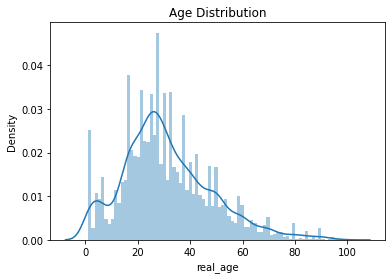

In [4]:
sns.distplot(labels["real_age"],  hist = True, bins=100).set(
    title="Age Distribution")
plt.show()

В датасете 7591 строка и 2 столбца с названиями фото людей и определённым возрастом.
Пропусков нет.
Большинство людей в возрасте от 20 до 41 года, около 50% данных в этом диапазоне. 

Ниже воспользуемся загрузчиком данных и посмотрим на 15 фотографий.

In [5]:
datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Идентифицировалось необходимое число, совпадающее с кол-м файлов в датасете - 7591.

In [7]:
features, target = next(train_gen_flow)

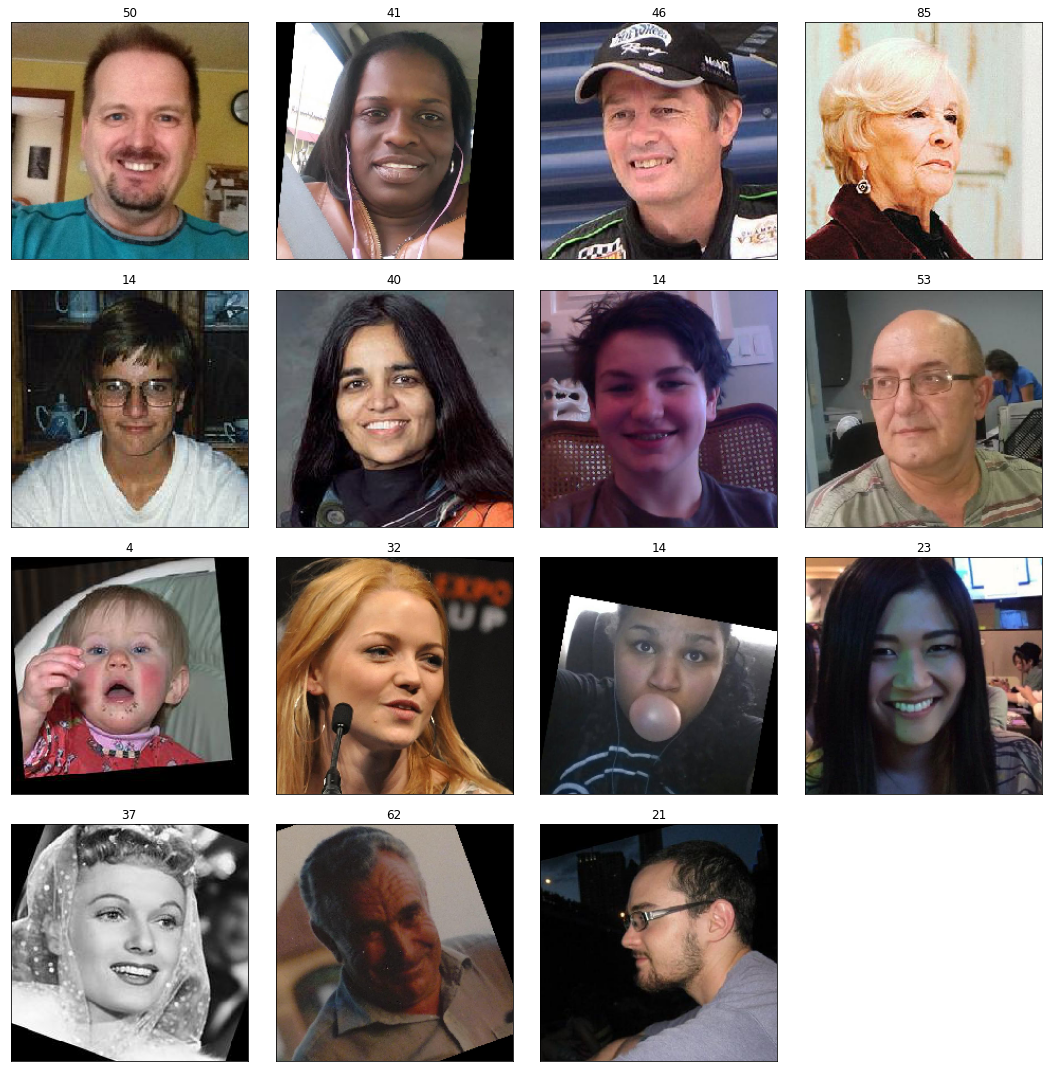

In [8]:
fig = plt.figure(figsize=(15,15))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title(target[i])

In [9]:
features.shape

(32, 224, 224, 3)

Некоторые фото наклонены, есть фото в оттенках серого. При обучении надо будет аугментировать трен. выборку.

# Обучение Модели

Загрузим данные:

Применим модель ResNet50 добавив сверху полносвязный слой с Relu активацией.  \
Обучим модель на 10 эпохах.

In [1]:
import numpy as np 
import pandas as pd 
from tensorflow.keras.layers import Conv2D, Flatten, AvgPool2D, Dense, GlobalAveragePooling2D 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.applications.resnet import ResNet50 


def load_train(path):

    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        horizontal_flip=True,
        subset='training',
        seed=12345)
    return train_datagen_flow

def load_test(path):

    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_datagen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape= input_shape,
                    weights='imagenet',
                    include_top= False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data= test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model
    
    

Результат вывода модели ниже:

2023-09-23 02:19:43.780517: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6 \
2023-09-23 02:19:43.782133: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6 \
2023-09-23 02:19:44.640768: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1 \
2023-09-23 02:19:45.244817: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0 \
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s \
2023-09-23 02:19:45.244898: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1 \
2023-09-23 02:19:45.244931: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10 \
2023-09-23 02:19:45.247002: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10 \
2023-09-23 02:19:45.247394: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10 \
2023-09-23 02:19:45.249446: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10 \
2023-09-23 02:19:45.250596: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10 \
2023-09-23 02:19:45.250660: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7 \
2023-09-23 02:19:45.253689: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend. \
Found 5694 validated image filenames. \
Found 1897 validated image filenames. \
2023-09-23 02:19:45.422317: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA \
2023-09-23 02:19:45.428283: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
2023-09-23 02:19:45.428796: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x47d1cb0 initialized for platform Host (this does not guarantee that XLA will be used). Devices: \
2023-09-23 02:19:45.428823: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version \
2023-09-23 02:19:45.564608: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x3e31fd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices: \
2023-09-23 02:19:45.564647: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0 \
2023-09-23 02:19:45.566376: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0 \
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s \
2023-09-23 02:19:45.566433: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1 \
2023-09-23 02:19:45.566443: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10 \
2023-09-23 02:19:45.566468: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10 \
2023-09-23 02:19:45.566478: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10 \
2023-09-23 02:19:45.566487: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10 \
2023-09-23 02:19:45.566503: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7 \
2023-09-23 02:19:45.569683: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2023-09-23 02:19:45.569742: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1 \
2023-09-23 02:19:45.566496: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10 \
2023-09-23 02:19:45.887416: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix: \
2023-09-23 02:19:45.887473: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0  \
2023-09-23 02:19:45.887482: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N  \
2023-09-23 02:19:45.890742: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0. \
2023-09-23 02:19:45.890791: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device  \(/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0) \
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 10s
    
   90112/94765736 [..............................] - ETA: 57s
   
  270336/94765736 [..............................] - ETA: 39s
  
  843776/94765736 [..............................] - ETA: 18s
  
 2318336/94765736 [..............................] - ETA: 8s 
 
 6316032/94765736 [>.............................] - ETA: 3s
 
10780672/94765736 [==>...........................] - ETA: 2s

14016512/94765736 [===>..........................] - ETA: 2s

18751488/94765736 [====>.........................] - ETA: 1s

23150592/94765736 [======>.......................] - ETA: 1s

26402816/94765736 [=======>......................] - ETA: 1s

31154176/94765736 [========>.....................] - ETA: 1s

35454976/94765736 [==========>...................] - ETA: 1s

39813120/94765736 [===========>..................] - ETA: 0s

44507136/94765736 [=============>................] - ETA: 0s

47816704/94765736 [==============>...............] - ETA: 0s

52305920/94765736 [===============>..............] - ETA: 0s

56934400/94765736 [=================>............] - ETA: 0s

60252160/94765736 [==================>...........] - ETA: 0s

64692224/94765736 [===================>..........] - ETA: 0s

69369856/94765736 [====================>.........] - ETA: 0s

72736768/94765736 [======================>.......] - ETA: 0s

77062144/94765736 [=======================>......] - ETA: 0s

81698816/94765736 [========================>.....] - ETA: 0s

85204992/94765736 [=========================>....] - ETA: 0s

89473024/94765736 [===========================>..] - ETA: 0s

94085120/94765736 [============================>.] - ETA: 0s

94773248/94765736 [==============================] - 1s 0us/step \
<class 'tensorflow.python.keras.engine.sequential.Sequential'> \
WARNING:tensorflow:sample_weight modes were coerced from \
  ... \
    to  \ 
  ['...'] \
WARNING:tensorflow:sample_weight modes were coerced from \
  ... \
    to  \ 
  ['...'] \
Train for 178 steps, validate for 60 steps \
Epoch 1/9
2023-09-23 02:19:57.498920: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10 \
2023-09-23 02:19:57.787124: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7 \
178/178 - 46s - loss: 199.1009 - mae: 10.5080 - val_loss: 399.9564 - val_mae: 16.9003 \

Epoch 2/9
178/178 - 38s - loss: 101.4502 - mae: 7.6416 - val_loss: 447.7810 - val_mae: 16.0817

Epoch 3/9
178/178 - 38s - loss: 69.9009 - mae: 6.3853 - val_loss: 396.4489 - val_mae: 14.8724

Epoch 4/9
178/178 - 38s - loss: 45.3880 - mae: 5.2096 - val_loss: 175.6896 - val_mae: 10.0101

Epoch 5/9
178/178 - 38s - loss: 28.4547 - mae: 4.0829 - val_loss: 108.4145 - val_mae: 7.8638

Epoch 6/9
178/178 - 38s - loss: 18.1395 - mae: 3.2731 - val_loss: 89.2535 - val_mae: 7.0887

Epoch 7/9
178/178 - 38s - loss: 16.8302 - mae: 3.1463 - val_loss: 81.5586 - val_mae: 6.8966

Epoch 8/9
178/178 - 38s - loss: 14.2297 - mae: 2.9206 - val_loss: 86.6880 - val_mae: 7.2309

Epoch 9/9
178/178 - 38s - loss: 10.9841 - mae: 2.5310 - val_loss: 73.8794 - val_mae: 6.4821

WARNING:tensorflow:sample_weight modes were coerced from
    to  
  ['...']
  ...
60/60 - 9s - loss: 73.8794 - mae: 6.4821 \
**Test MAE: 6.4821**

# Анализ обученной модели

В задаче мы использовали ResNet50 - сверточную нейронную сетью, которая имеет 50 слоёв глубины. Она у нас предварительно обучена на больше чем миллионе изображений от базы данных ImageNet. Конкретно под нашу задачу в процессе мы убрали выходной слой с тысячей нейронов, оставив только "каркас" (backbone) от сети, заменив в конце связью пулинга и полносвязного слоя с 1 нейроном для задачи классификации с функцией активации "relu" и оптимайзером "Adam". Функцией потерь, использованной в модели, стала MSE.
Модель достигла метрики требуемого значения MAE (ниже 7), но, как мы видим, для получения MAE менее 7 мы также попробовать уменьшить кол-во эпох до 7 и получить результат раньше.

# Вывод

Мы открыли и изучили датасет состоящий из 7591 фото с указанием возраста людей, которые там запечатлены.
Проведя исследовательский анализ набора фотографий, мы выяснили, что некоторая часть изображений наклонена или имеет бесцветный оттенок. Около половины людей на фото из датасета принадлежат к возрастной группе от 20 до 41 года. 
Затем мы обучили свёрточную нейросеть определять возраст по фото и преодолели нижний порог метрики МАЕ, который равен 7.
Наша нейросеть достигла метрики требуемого значения MAE - 6.48.